## Create Initial states

In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP
from src.models.system_rul import SystemRUL

In [2]:
data_name = "DS03"

device = "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [4]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [5]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].unique().tolist()

In [6]:
performs_train = {alias: 
    {int(unit): hi_df[hi_df['unit']==unit][alias].values for unit in units} 
    for alias in perform_alias
}
time_train = {int(unit): hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Load best model

In [11]:
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)
trian_units = range(1,9)
test_unit = 9
pf_models: dict[str,ParticleFilterModel]= {}
observations = {}
for name, units_perform in performs_train.items():
    models = []
    obs_test = {}
    for unit, perform in units_perform.items():
        if unit in trian_units:
            best_model = NModel()
            best_model.load_state_dict(
				torch.load(states_dir /name/f'unit_{unit}'/ "best_model.pt", map_location=device)
			)
            best_model.to(device)
            best_model.eval()
            models.append(best_model)
        else:
            obs_test[unit] = perform,time_train[unit]
            
    observations[name]=obs_test
    pf_models[name]=ParticleFilterModel(base_models=models,
                        net=ParticleFilterMLP(layer_dims=[3, 16]),
                        max_life = 100.0,
                        multiply_scale=0.01,
                        n_particles=800,
                        name = name).to(device)

system_model = SystemRUL(pf_models=pf_models)

## System RUL

In [12]:
frames = []
t_grid = t
s_grid = s
n_performs = len(system_model.pf_models)
time_full = time_train[test_unit]

system_model.reset_history()


for k, t_curr in enumerate(time_full):
    system_model.observe(
        time=t_curr,
        observations={
            name: performs_train[name][test_unit][k]
            for name in system_model.pf_models
        },
    )

    system_model.step(
        noise_scales={'T48': 0.1,
                      'SmLPC': 0.1,
                      'SmHPC': 0.1}
    )

    system_model.record(t_curr)

    # --- render frame ---
    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(
		2, 3,
		width_ratios=[2.8, 2, 2],
		wspace=0.15,
		hspace=0.20,
	)
    
    ax_rul = fig.add_subplot(gs[:, 0])
    ax_pf = [
		fig.add_subplot(gs[0, 1]),
		fig.add_subplot(gs[0, 2]),
		fig.add_subplot(gs[1, 1]),
	]
    
    fig.add_subplot(gs[1, 2]).axis("off")  # empty slot
		
    
    for ax, (name, pf) in zip(ax_pf,system_model.pf_models.items()):
        pf.plot(
            ax=ax,
            t_grid=t_grid,
            s_grid=s_grid,
            t_obs=np.asarray(system_model.t_obs),
            s_obs=np.asarray(system_model.s_obs[name]),
            title=f"{name} | unit {test_unit} | step {k}",
        )

    system_model.plot_rul(
        ax=ax_rul,
        eol_time=time_full[-1],
        y_max=50,
        title=f"System RUL – unit {test_unit}",
    )

    fig.canvas.draw()
    frame = np.asarray(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    frames.append(frame)

/var/folders/hl/2v5kr9994fl_j6sv_4mt0bn00000gn/T/ipykernel_26373/1391099475.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()


## Save video

In [13]:
import imageio

video_path = "pf_full.mp4"

with imageio.get_writer(video_path, fps=8, macro_block_size=1) as writer:
    for frame in frames:
        writer.append_data(frame)

print(f"🎬 Video saved to {video_path}")

🎬 Video saved to pf_full.mp4


## Plot System RUL

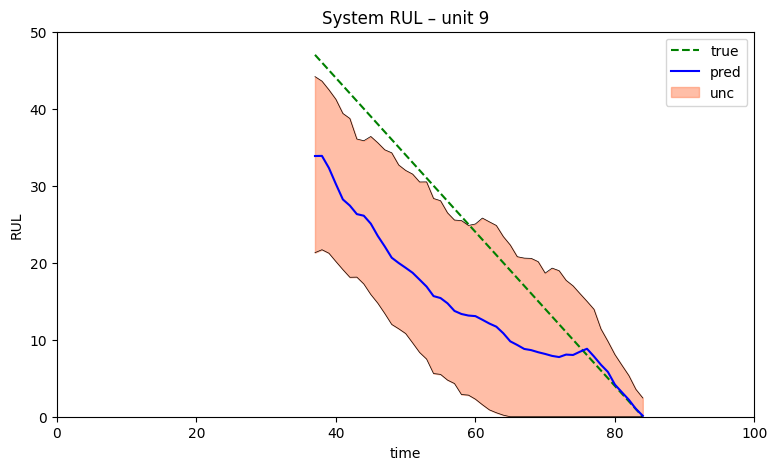

In [14]:
fig, ax = plt.subplots(figsize=(9, 5))

system_model.plot_rul(
    ax=ax,
    eol_time=time_full[-1],
    y_max= 50,
    title=f"System RUL – unit {test_unit}",
)

plt.show()

## Save video